# How to access the data

## Incarceration rate by state
1. **Enter the website**: You can download the dataset from [this link](https://bjs.ojp.gov/data-collection/national-prisoner-statistics-nps#2-0).
2. Navgiate to Publication and Product. Here you will seee publications of important prisoner data sorted in tables. The most recent years that can be found is 2023: https://bjs.ojp.gov/document/p23st.pdf 
3. The data should already be on this Github repository, under the `Data` folder. For the incarceration rate the file is called `p23st.pdf`. For 2020, the file is called `p20st.pdf`. 
4. There is also the data in csv format:
- 2023: `data/p23stf02.csv`, `data/p23stt02.csv` \
- 2020: `data/p20stat02.csv`, `data/p20stf02.csv`

## Violent Crime rate by state

1. **Enter the website**: You can download the dataset from [this link](https://cde.ucr.cjis.gov/LATEST/webapp/#). 
2. Navigate to this section. Download the csv folders. There should be a csv file that contains the data for each state.
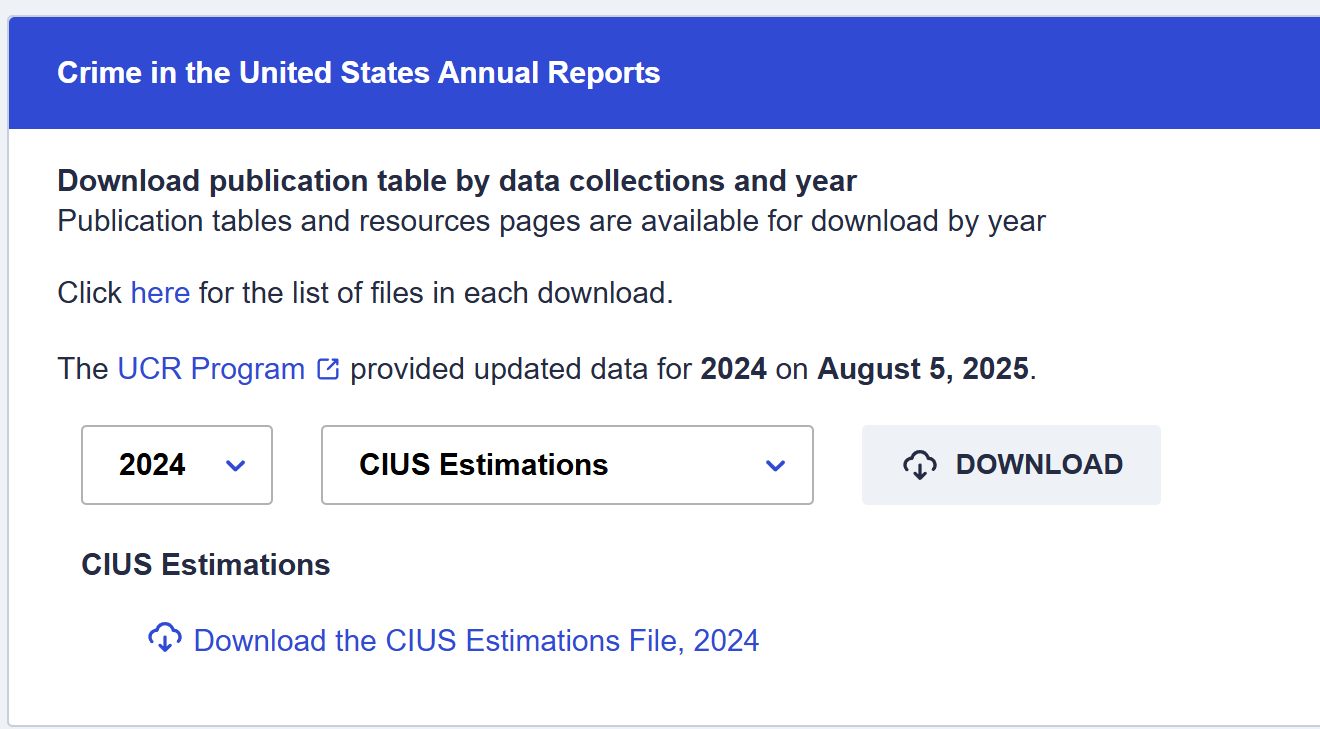
3. The data should already be on this Github repository, under the `Data` folder. For the violent crime rate the file is called `Table_4_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2022-2023` for the 2022-2023 data, and `Table_04_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2019-2020` for the 2019-2020 data.

# Create the plots

Part 2. Data visualizations 
Regardless of which option you choose, you must produce two related figures. 

**Figure 1: Levels (cross-section)**
- Scatterplot showing: 
    - One dot per state 
    - Both variables measured in the same year 

**Figure 2: Changes over time (panel)**
- Scatterplot showing changes in the same two variables: 
    - One dot per state 
    - Change = value in a later year minus value in an earlier year 
    - Use the same time window for both variables (e.g., 2000-2019) 
    
For both figures, please have a clear title and axis labels (including units and years) and 
use sensible scaling (do not truncate axes unless explicitly justified). No need for 
regression lines. Simple is better. 

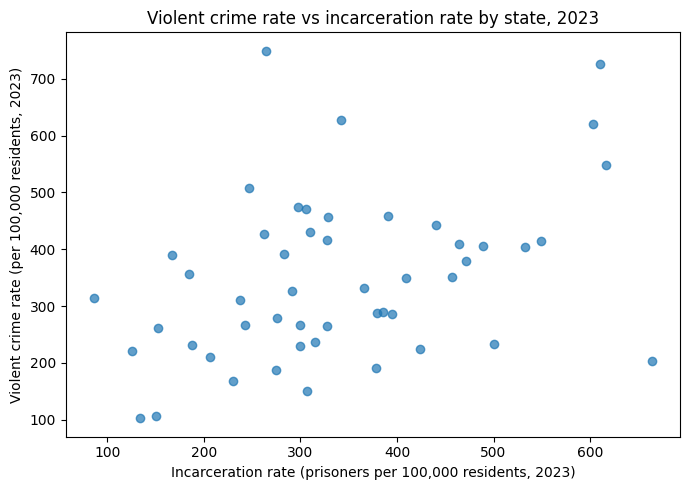

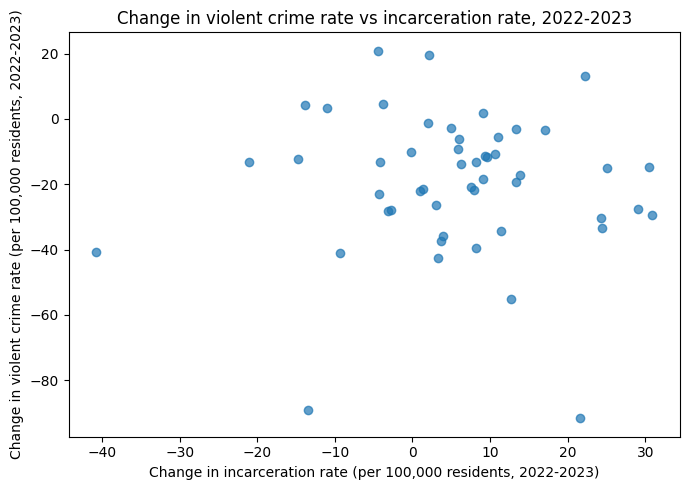

In [5]:
#%pip install pandas matplotlib openpyxl xlrd
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

data_dir = Path("data")
prison_path = data_dir / "p23stt02.csv"
crime_path = data_dir / "Table_4_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2022-2023.xlsx"

import re
from pathlib import Path
import pandas as pd

def clean_state_name(value: str) -> str:
    value = str(value).strip()
    value = re.sub(r"/.*$", "", value)          # removes things like Federal/a
    value = value.replace("�", "-")             # fix weird hyphen
    value = re.sub(r"\s*\d+\s*$", "", value)    # removes footnote digits like Florida4
    return value

def build_columns(main: pd.Series, sub: pd.Series) -> list[str]:
    main = main.fillna("").astype(str).str.strip()
    sub  = sub.fillna("").astype(str).str.strip()
    main = main.replace("", pd.NA).ffill()

    cols = []
    for m, s in zip(main, sub):
        if str(s).strip() and str(m).strip() and s != m:
            cols.append(f"{m} {s}")
        elif str(m).strip():
            cols.append(str(m))
        else:
            cols.append(str(s))
    return cols

def read_crime_table(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    raw = xls.parse(xls.sheet_names[0], header=None, dtype=str)

    # In your file, header is at row 3 ("Area", "Year") and row 4 is subheader
    header_idx = None
    for i in range(50):
        row = raw.iloc[i].fillna("").astype(str).str.strip().tolist()
        if "Area" in row and "Year" in row:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError("Could not locate crime table header.")

    cols = build_columns(raw.iloc[header_idx], raw.iloc[header_idx + 1])
    df = raw.iloc[header_idx + 2 :].copy()
    df.columns = cols
    df = df.dropna(how="all")

    # forward-fill State/Area FIRST, because 2023 rows have blank Area cells
    df["Area"] = df["Area"].map(lambda x: clean_state_name(x) if pd.notna(x) else x).ffill()

    # keep only actual year rows (drop percent change rows)
    df["Year"] = df["Year"].astype(str).str.strip()
    df = df[df["Year"].isin(["2022", "2023"])].copy()

    df = df.rename(columns={"Area": "State"})
    return df

def read_prison_table(path: Path) -> pd.DataFrame:
    raw = pd.read_csv(path, header=None, dtype=str, encoding="cp1252")

    # find the row that contains both 2022 and 2023 (year labels row)
    year_row = None
    for i in range(30):
        row = raw.iloc[i].fillna("").astype(str).str.strip().tolist()
        if "2022" in row and "2023" in row:
            year_row = i
            break
    if year_row is None:
        raise ValueError("Could not find 2022/2023 year header row in prison CSV.")

    header_row = year_row + 1
    year_labels = raw.iloc[year_row].fillna("").astype(str).str.strip()
    headers     = raw.iloc[header_row].fillna("").astype(str).str.strip()

    # identify the "Total" columns under each year
    col_2022_total = next((j for j in range(len(headers))
                          if year_labels[j] == "2022" and headers[j] == "Total"), None)
    col_2023_total = next((j for j in range(len(headers))
                          if year_labels[j] == "2023" and headers[j] == "Total"), None)
    if col_2022_total is None or col_2023_total is None:
        raise ValueError("Could not locate Total columns for 2022/2023 in prison table.")

    # pick the column that actually contains jurisdiction values (often right of the Jurisdiction label)
    jurisdiction_label_col = next((j for j, v in enumerate(headers) if "Jurisdiction" in v), 0)

    df = raw.iloc[header_row + 1 :].copy().dropna(how="all")
    cand_cols = [jurisdiction_label_col, jurisdiction_label_col + 1]
    jurisdiction_data_col = max(
        [j for j in cand_cols if j < df.shape[1]],
        key=lambda j: df.iloc[:, j].notna().sum()
    )

    df["State"] = df.iloc[:, jurisdiction_data_col].map(
        lambda x: clean_state_name(x) if pd.notna(x) else x
    )

    df = df[df["State"].notna()].copy()
    df = df[~df["State"].isin(["U.S. total", "Federal", "State", "FBOP"])].copy()

    df["prison_total_2022"] = pd.to_numeric(df.iloc[:, col_2022_total].str.replace(",", "", regex=False),
                                            errors="coerce")
    df["prison_total_2023"] = pd.to_numeric(df.iloc[:, col_2023_total].str.replace(",", "", regex=False),
                                            errors="coerce")

    return df[["State", "prison_total_2022", "prison_total_2023"]]


def find_col(cols, year, keywords):
    for c in cols:
        name = str(c).lower()
        if str(year) in name and all(k in name for k in keywords):
            return c
    return None

def get_crime_year(crime_df: pd.DataFrame, year: int) -> pd.DataFrame:
    year_col = next((
        c for c in crime_df.columns if str(c).strip().lower() == "year"
    ), None)
    pop_col = next((
        c for c in crime_df.columns if "population" in str(c).lower()
    ), None)
    violent_rate_col = next((
        c for c in crime_df.columns
        if "violent crime" in str(c).lower() and "rate" in str(c).lower()
    ), None)
    if year_col and pop_col and violent_rate_col:
        subset = crime_df[
            crime_df[year_col].astype(str).str.contains(str(year), na=False)
        ].copy()
        subset = subset[["State", pop_col, violent_rate_col]]
        subset.columns = ["State", f"population_{year}", f"violent_rate_{year}"]
    else:
        cols = list(crime_df.columns)
        pop_col = find_col(cols, year, ["population"])
        violent_col = find_col(cols, year, ["violent", "rate"])
        if not pop_col or not violent_col:
            raise ValueError(f"Missing crime columns for {year}.")
        subset = crime_df[["State", pop_col, violent_col]].copy()
        subset.columns = ["State", f"population_{year}", f"violent_rate_{year}"]
    subset[f"population_{year}"] = pd.to_numeric(subset[f"population_{year}"], errors="coerce")
    subset[f"violent_rate_{year}"] = pd.to_numeric(subset[f"violent_rate_{year}"], errors="coerce")
    return subset

crime = read_crime_table(crime_path)
prison = read_prison_table(prison_path).rename(columns={"Jurisdiction": "State"})

crime_2022 = get_crime_year(crime, 2022)
crime_2023 = get_crime_year(crime, 2023)

df = (
    crime_2022.merge(crime_2023, on="State", how="inner")
    .merge(prison, on="State", how="inner")
)
df["incarceration_rate_2022"] = df["prison_total_2022"] / df["population_2022"] * 100000
df["incarceration_rate_2023"] = df["prison_total_2023"] / df["population_2023"] * 100000
df = df.dropna(subset=["incarceration_rate_2022", "incarceration_rate_2023", "violent_rate_2022", "violent_rate_2023"])

plt.figure(figsize=(7, 5))
plt.scatter(df["incarceration_rate_2023"], df["violent_rate_2023"], alpha=0.7)
plt.title("Violent crime rate vs incarceration rate by state, 2023")
plt.xlabel("Incarceration rate (prisoners per 100,000 residents, 2023)")
plt.ylabel("Violent crime rate (per 100,000 residents, 2023)")
plt.tight_layout()
plt.show()

df["incarceration_change"] = df["incarceration_rate_2023"] - df["incarceration_rate_2022"]
df["violent_change"] = df["violent_rate_2023"] - df["violent_rate_2022"]

plt.figure(figsize=(7, 5))
plt.scatter(df["incarceration_change"], df["violent_change"], alpha=0.7)
plt.title("Change in violent crime rate vs incarceration rate, 2022-2023")
plt.xlabel("Change in incarceration rate (per 100,000 residents, 2022-2023)")
plt.ylabel("Change in violent crime rate (per 100,000 residents, 2022-2023)")
plt.tight_layout()
plt.show()

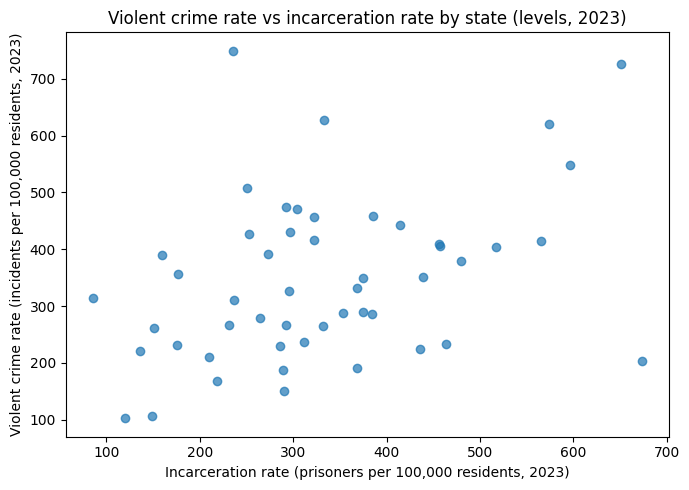

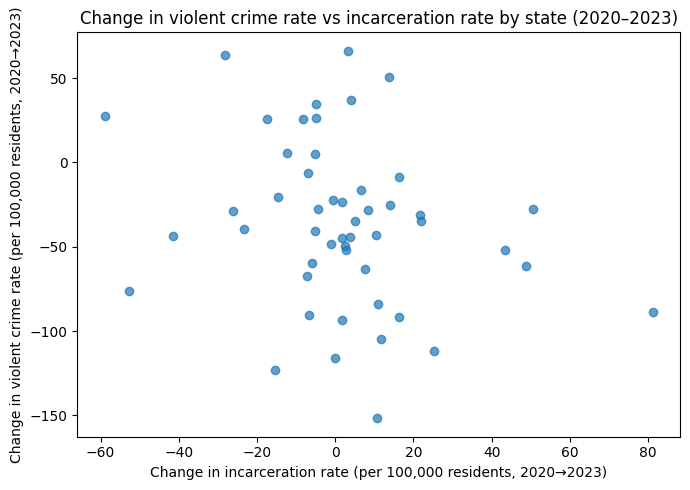

In [ ]:
# 2020-2023 window
# crime_2020_path = data_dir / "Table_04_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2019-2020.xls"
# crime_2023_path = data_dir / "Table_4_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2022-2023.xlsx"
# prison_2020_path = data_dir / "p20stat02.csv"
# prison_2023_path = data_dir / "p23stt02.csv"

import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def clean_state_name(value: str) -> str:
    value = str(value).strip()
    value = re.sub(r"/.*$", "", value)
    value = value.replace("�", "-")
    value = re.sub(r"\s*\d+\s*$", "", value)
    return value

def build_columns(main: pd.Series, sub: pd.Series) -> list[str]:
    main = main.fillna("").astype(str).str.strip()
    sub  = sub.fillna("").astype(str).str.strip()
    main = main.replace("", pd.NA).ffill()

    cols = []
    for m, s in zip(main, sub):
        if str(s).strip() and str(m).strip() and s != m:
            cols.append(f"{m} {s}")
        elif str(m).strip():
            cols.append(str(m))
        else:
            cols.append(str(s))
    return cols

def read_crime_table_any(path: Path) -> pd.DataFrame:
    """
    Reads the FBI Table_4 style file (.xls or .xlsx) and returns a tidy-ish DF
    with at least columns: State, Year, Population, Violent crime rate.
    """
    # ExcelFile works for both, but .xls may need xlrd installed and used.
    # If you get an error here, install xlrd==2.x and make sure you're not using old xlrd for xlsx.
    xls = pd.ExcelFile(path)
    raw = xls.parse(xls.sheet_names[0], header=None, dtype=str)

    header_idx = None
    for i in range(60):
        row = raw.iloc[i].fillna("").astype(str).str.strip().tolist()
        if "Area" in row and "Year" in row:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not locate crime header in {path.name}")

    cols = build_columns(raw.iloc[header_idx], raw.iloc[header_idx + 1])
    df = raw.iloc[header_idx + 2 :].copy()
    df.columns = cols
    df = df.dropna(how="all")

    if "Area" not in df.columns or "Year" not in df.columns:
        raise ValueError(f"Crime table missing Area/Year columns in {path.name}")

    df["Area"] = df["Area"].map(lambda x: clean_state_name(x) if pd.notna(x) else x).ffill()
    df["Year"] = df["Year"].astype(str).str.strip()

    df = df[df["Year"].str.fullmatch(r"\d{4}", na=False)].copy()

    df = df.rename(columns={"Area": "State"})
    return df

def get_crime_year(crime_df: pd.DataFrame, year: int) -> pd.DataFrame:
    year_str = str(year)

    # locate key columns
    year_col = next((c for c in crime_df.columns if str(c).strip().lower() == "year"), None)
    pop_col = next((c for c in crime_df.columns if "population" in str(c).lower()), None)

    # violent rate column varies but usually contains "Violent crime" + "rate"
    violent_rate_col = next((
        c for c in crime_df.columns
        if "violent" in str(c).lower() and "rate" in str(c).lower()
    ), None)

    if not (year_col and pop_col and violent_rate_col):
        raise ValueError(f"Missing Year/Population/Violent-rate columns for {year_str}")

    subset = crime_df[crime_df[year_col].astype(str).str.strip() == year_str].copy()
    subset = subset[["State", pop_col, violent_rate_col]].copy()
    subset.columns = ["State", f"population_{year_str}", f"violent_rate_{year_str}"]

    subset[f"population_{year}"] = pd.to_numeric(subset[f"population_{year}"], errors="coerce")
    subset[f"violent_rate_{year}"] = pd.to_numeric(subset[f"violent_rate_{year}"], errors="coerce")
    subset["State"] = subset["State"].map(clean_state_name)

    return subset


def read_prison_total_one_year(path: Path, year: int) -> pd.DataFrame:
    raw = pd.read_csv(path, header=None, dtype=str, encoding="cp1252")

    header_idx = None
    for i in range(60):
        row = raw.iloc[i].fillna("").astype(str).str.strip().tolist()
        if "Jurisdiction" in row and "Total" in row:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not locate prison header in {path.name}")

    header = raw.iloc[header_idx].fillna("").astype(str).str.strip().tolist()
    df = raw.iloc[header_idx + 1 :].copy()
    df.columns = header
    df = df.dropna(how="all")

    # Jurisdiction column (and sometimes values are actually in the next column)
    juris_col = next((c for c in df.columns if str(c).strip() == "Jurisdiction"), df.columns[0])
    state_series = df[juris_col]
    if isinstance(state_series, pd.DataFrame):
        state_series = state_series.iloc[:, 0]

    # If the jurisdiction column looks like labels, fall back to the next column
    if state_series.astype(str).str.contains("Jurisdiction", na=False).any():
        j_idx = list(df.columns).index(juris_col)
        if j_idx + 1 < df.shape[1]:
            state_series = df.iloc[:, j_idx + 1]

    total_candidates = [c for c in df.columns if str(c).strip() == "Total"]
    if not total_candidates:
        raise ValueError(f"Could not find Total column in {path.name}")

    # If duplicates, pick the one that parses to the most numeric values
    best_col = None
    best_nonnull = -1
    for c in total_candidates:
        col = df.loc[:, c]
        if isinstance(col, pd.DataFrame):  # duplicate name -> DataFrame
            for j in range(col.shape[1]):
                s = col.iloc[:, j]
                nums = pd.to_numeric(
                    s.astype(str)
                     .str.replace(",", "", regex=False)
                     .replace({"/": pd.NA, "~": pd.NA, "": pd.NA}),
                    errors="coerce"
                )
                nn = nums.notna().sum()
                if nn > best_nonnull:
                    best_nonnull = nn
                    best_col = (c, j)
        else:  # Series
            s = col
            nums = pd.to_numeric(
                s.astype(str)
                 .str.replace(",", "", regex=False)
                 .replace({"/": pd.NA, "~": pd.NA, "": pd.NA}),
                errors="coerce"
            )
            nn = nums.notna().sum()
            if nn > best_nonnull:
                best_nonnull = nn
                best_col = (c, None)

    c, j = best_col
    total_series = df.loc[:, c]
    if isinstance(total_series, pd.DataFrame):
        total_series = total_series.iloc[:, j]

    out = pd.DataFrame({
        "State": state_series.map(lambda x: clean_state_name(x) if pd.notna(x) else x),
        f"prison_total_{year}": pd.to_numeric(
            total_series.astype(str)
                        .str.replace(",", "", regex=False)
                        .replace({"/": pd.NA, "~": pd.NA, "": pd.NA}),
            errors="coerce"
        )
    })

    out = out[out["State"].notna()].copy()
    out = out[~out["State"].isin(["U.S. total", "Federal", "State", "FBOP"])].copy()
    return out


data_dir = Path("data")

crime_2020_path = data_dir / "Table_04_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2019-2020.xls"
crime_2023_path = data_dir / "Table_4_Crime_in_the_United_States_by_Region_Geographic_Division_and_State_2022-2023.xlsx"
prison_2020_path = data_dir / "p20stat02.csv"
prison_2023_path = data_dir / "p23stt02.csv"

crime_2020 = get_crime_year(read_crime_table_any(crime_2020_path), 2020)
crime_2023 = get_crime_year(read_crime_table_any(crime_2023_path), 2023)

prison_2020 = read_prison_total_one_year(prison_2020_path, 2020)
prison_2023 = read_prison_total_one_year(prison_2023_path, 2023)

df_2020_2023 = (
    crime_2020.merge(crime_2023, on="State", how="inner")
              .merge(prison_2020, on="State", how="inner")
              .merge(prison_2023, on="State", how="inner")
)

df_2020_2023["incarceration_rate_2020"] = df_2020_2023["prison_total_2020"] / df_2020_2023["population_2020"] * 100000
df_2020_2023["incarceration_rate_2023"] = df_2020_2023["prison_total_2023"] / df_2020_2023["population_2023"] * 100000

df_2020_2023 = df_2020_2023.dropna(subset=[
    "incarceration_rate_2020", "incarceration_rate_2023",
    "violent_rate_2020", "violent_rate_2023"
]).copy()

# Figure 1: Levels (same year)
plt.figure(figsize=(7, 5))
plt.scatter(df_2020_2023["incarceration_rate_2023"], df_2020_2023["violent_rate_2023"], alpha=0.7)
plt.title("Violent crime rate vs incarceration rate by state (levels, 2023)")
plt.xlabel("Incarceration rate (prisoners per 100,000 residents, 2023)")
plt.ylabel("Violent crime rate (incidents per 100,000 residents, 2023)")
plt.tight_layout()
plt.show()

# Figure 2: Changes (same window)
df_2020_2023["incarceration_change_2020_2023"] = df_2020_2023["incarceration_rate_2023"] - df_2020_2023["incarceration_rate_2020"]
df_2020_2023["violent_change_2020_2023"] = df_2020_2023["violent_rate_2023"] - df_2020_2023["violent_rate_2020"]

plt.figure(figsize=(7, 5))
plt.scatter(df_2020_2023["incarceration_change_2020_2023"], df_2020_2023["violent_change_2020_2023"], alpha=0.7)
plt.title("Change in violent crime rate vs incarceration rate by state (2020–2023)")
plt.xlabel("Change in incarceration rate (per 100,000 residents, 2020→2023)")
plt.ylabel("Change in violent crime rate (per 100,000 residents, 2020→2023)")
plt.tight_layout()
plt.show()


# Citations
1. UCR Summary of Reported Crimes in the Nation, 2024. https://cde.ucr.cjis.gov/LATEST/resources/reports/UCR%20Summary%20of%20Reported%20Crimes%20in%20the%20Nation%202024.pdf 
2. https://cde.ucr.cjis.gov/LATEST/webapp/#
3. https://bjs.ojp.gov/content/pub/pdf/p20st.pdf
4. https://bjs.ojp.gov/content/pub/pdf/p20st.pdf